## keypoints 전처리
- 영상 폴더 안 여러 개 json -> 하나의 txt
- keypoints 전처리 내용
    - pose, face, hand 다 1차원 리스트로 연결
    - confidence 값 제외
    - pose에서 하반신 0 제외
    - 그 외의 0 값 앞 뒤 평균으로 채우기
    - 0~1 scaling

In [1]:
import json
import os
import glob
import numpy as np

In [2]:
# 경로 설정
kp_path = './SENTENCE_REAL001/키포인트Json/' # 기존 키포인트 Json
new_kp_dir = './SENTENCE_REAL001/키포인트txt/' # 새로 저장할 키포인트 txt

#### 키포인트Json 폴더 아래 모든 json 파일 불러오기

In [3]:
json_files = glob.glob(os.path.join(kp_path,'**','*.json'), recursive=True)

#### keypoints 처리(연결, 0값제외, 값 채우기)
- 연속해서 같은 부분에 0인 값이 나오는 경우는 없다고 생각하고 짠 코드인데 혹시 있어서 0이 다 채워지지 않거나 하면 이야기 해주세요!

In [4]:
keypointss = []
ZERO = False
for i, json_file in enumerate(json_files):
    with open(json_file, "r") as keypoints_json:
        data = json.load(keypoints_json)
 
    # pose에서 생략 가능한 하반신 30-35, 39-44, 57-74
    pose = data['people'][0]['pose_keypoints_2d']
    pose = pose[:30]+pose[36:39]+pose[45:57] # pose 75개 -> 45개
    face = data['people'][0]['face_keypoints_2d']
    hand_left = data['people'][0]['hand_left_keypoints_2d']
    hand_right = data['people'][0]['hand_right_keypoints_2d']
    
    # 전체 keypoints 합치고 confidence 값 제외
    entire_keypoints = np.array(pose+face+hand_left+hand_right, dtype=np.float32).reshape(-1,3)[:,:2].flatten() # 254
    keypointss.append(entire_keypoints) # 일단 keypointss 리스트에 다 저장 - 0값 채우기 위해서
    
    if i>1 and ZERO: # 앞에 0인 값이 있으면 i-2, i의 평균값으로 i-1의 0 채워주기
        zero_tf = keypointss[i-1]==0
        keypointss[i-1][zero_tf] = (keypointss[i-2][zero_tf]+keypointss[i][zero_tf])/2 # 앞,뒤 평균값으로 채워주기
        ZERO = False
        
    if 0 in entire_keypoints: # 0이 있으면 ZERO!
        ZERO = True

#### 0~1
- 이미지 크기 2048 1152
- 여기서 1보다 큰 값은 이미지 밖에 찍히는 부분!

In [5]:
def normalization(array):
    scale_array = array.copy()
    scale_array[::2] /= 2048 # x좌표
    scale_array[1::2] /= 1152 # y좌표
    return scale_array

#### 혹시 0이 있나 확인,, 여기서 아직 0인 값 있으면 안돼!!!

In [7]:
for json_file, keypoints in zip(json_files, keypointss):
    if 0 in keypoints:
        print(json_file, keypoints)
        break

#### 저장

In [6]:
os.makedirs(new_kp_dir, exist_ok=True) # 폴더 만들고
for json_file, keypoints in zip(json_files, keypointss):
    txt_file_name = os.path.basename(os.path.dirname(json_file))
    f = open(new_kp_dir+txt_file_name[:-4]+'.txt', 'a')
    # 저장
    data = "%s, " %os.path.basename(json_file)[:-5] + ', '.join(list(map(str,normalization(keypoints)))) + '\n' # keypoints 값에 normalization 적용해서
    f.write(data)
    f.close()

#### 결과

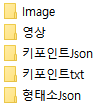

키포인트txt 폴더가 생기고

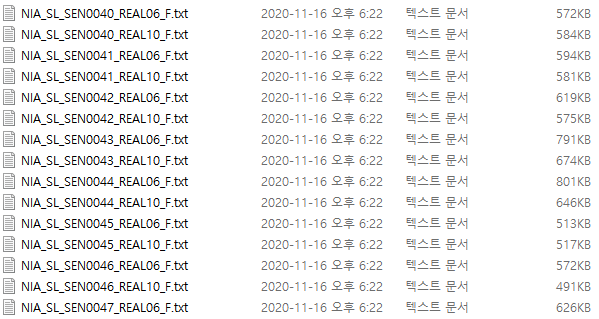

영상 별 txt 파일이 생기고

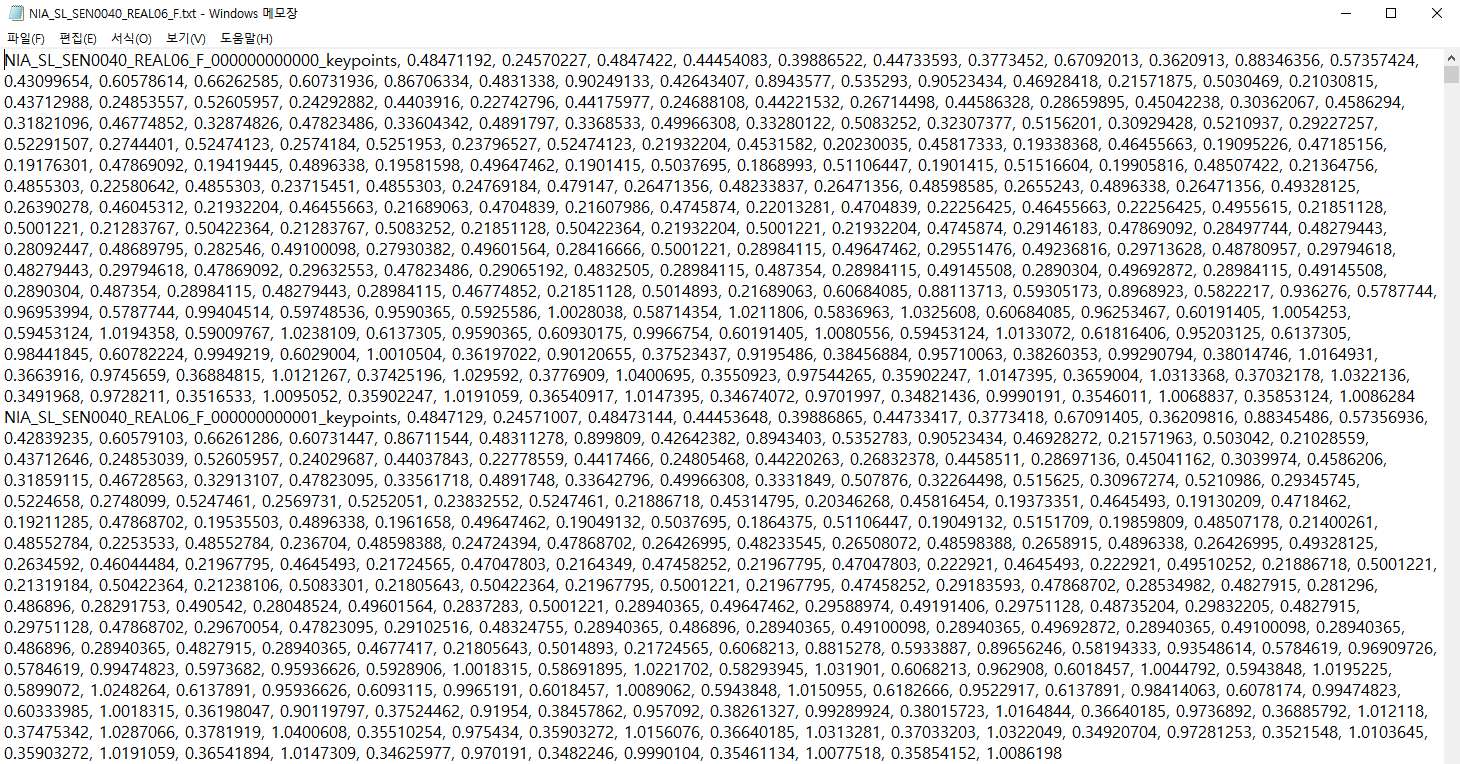

txt 안의 내용은 이렇게!   
'이미지 frame 이름+_keypoints', keypoints 값들     
불러올때는 한줄씩 읽어서 [0]이 frame 이름, [1:]이 keypoints 값 254개